In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam   
import numpy as np
import matplotlib.pyplot as plt
import os 
import time
import PIL
from PIL import Image
from IPython import display
from tqdm import tqdm
from os import listdir
from matplotlib import image
import imageio
import glob
tf.__version__

'2.4.1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Downloading and Extracting Data: Don't run this everytime

In [ ]:
from google.colab import files
files.upload()  #kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

!kaggle datasets download -d arnaud58/landscape-pictures -p /content/gdrive/MyDrive/GAN/

In [ ]:
import zipfile
folder = "/content/drive/.shortcut-targets-by-id/10baK0o8l3nx1BRBRkEe3vdMraTi8V8dG/GAN/"
with zipfile.ZipFile(folder + "landscape-pictures.zip", 'r') as zip_ref:
    zip_ref.extractall(folder+"landscape128")

## Defining global variables

In [ ]:
DIMS = 128
folder = "/content/drive/MyDrive/GAN/landscape128_final/" #Parent folder
BUFFER_SIZE = 6000
BATCH_SIZE = 32
SEED_SIZE = 100
EPOCHS = 400
IMAGE_COUNT = 100

## Resizing original files: Dont't run this everytime

In [ ]:
loaded_images = list()
for filename in tqdm(os.listdir(folder)):
  f_img = os.path.join(folder, filename)
  img_data = Image.open(f_img).resize((DIMS, DIMS), Image.ANTIALIAS)
  if img_data.size != (DIMS,DIMS):
    print(f"Err, shape = {img_data.size}")
  else:
    img_data.save(f_img)
    loaded_images.append(img_data)

### Now you're sorted

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

## Loading images into numpy array

In [ ]:
training_data_path = os.path.join(folder,f'training_data_{DIMS}X{DIMS}.npy')
print(f"Looking for file: {training_data_path}")

if not os.path.isfile(training_data_path):
  start = time.time()
  print("Loading training images...")
  training_data = []
  for filename in tqdm(os.listdir(folder)):
      path = os.path.join(folder,filename)
      image = Image.open(path).resize((DIMS,DIMS),Image.ANTIALIAS)
      if np.asarray(image).shape == (DIMS, DIMS, 3):
        training_data.append(np.asarray(image))
  
  training_data = np.reshape(training_data,(-1,DIMS,DIMS,3))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.
  print("Saving training images in numpy file...")
  np.save(training_data_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocessing time: {hms_string(elapsed)}')

else:
  print("Loading previous training numpy file...")
  training_data = np.load(training_data_path)

Looking for file: /content/drive/.shortcut-targets-by-id/10baK0o8l3nx1BRBRkEe3vdMraTi8V8dG/GAN/landscape128/training_data_128X128.npy
Loading previous training numpy file...


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator Model

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4 * 4 * 256, activation="relu",input_dim=seed_size))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256)

    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    return model

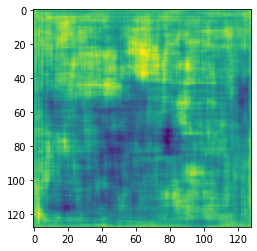

In [ ]:
generator = build_generator(SEED_SIZE, 3)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
generator.summary()

In [ ]:
if not os.path.isdir(os.path.join(folder,'models')):
  os.mkdir(os.path.join(folder,'models'))
model_path='/content/drive/MyDrive/GAN/landscape128_final/models'

In [ ]:
tf.keras.utils.plot_model(generator, to_file=os.path.join(model_path,'generator.png'), show_shapes=True, show_layer_names=True)

## Discriminator Model

In [ ]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
image_shape = (DIMS,DIMS,3)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.5000468]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.summary()

In [ ]:
tf.keras.utils.plot_model(generator, to_file=os.path.join(model_path,'discriminator.png'), show_shapes=True, show_layer_names=True)

## Defining loss functions and optimizers

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
checkpoint_dir = os.path.join(folder,"checkpoints1") #Checkpoint files generated will be stored in this new folder
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

## Training and Saving Images

In [ ]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (IMAGE_COUNT, SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},{hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [ ]:
def save_images(cnt,noise):
  generated_images = (generator.predict(noise)*0.5 + 0.5)*255
  output_path = os.path.join(folder,'Image128_test1') #Images generated will be stored in this new folder
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  for i in range(len(generated_images)):
    path = os.path.join(output_path, f'Image-{i+1}')
    if not os.path.exists(path):
      os.makedirs(path)

  for i in range(len(generated_images)):  
    filename = os.path.join(output_path,f"Image-{i+1}", f"Epoch-{cnt+1}.png")
    Image.fromarray(generated_images[i].astype(np.uint8)).save(filename)

In [ ]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=2.62335205078125,disc loss=1.2986334562301636,0:01:04.20
Epoch 2, gen loss=1.7020164728164673,disc loss=2.012425422668457,0:00:57.83
Epoch 3, gen loss=1.4805965423583984,disc loss=1.7562052011489868,0:00:57.20
Epoch 4, gen loss=1.5559747219085693,disc loss=1.688524842262268,0:00:57.03
Epoch 5, gen loss=1.520346760749817,disc loss=1.803109884262085,0:00:56.80
Epoch 6, gen loss=1.6257110834121704,disc loss=1.7886427640914917,0:00:56.99
Epoch 7, gen loss=1.4418102502822876,disc loss=1.6309421062469482,0:00:56.89
Epoch 8, gen loss=1.4624757766723633,disc loss=1.555160641670227,0:00:56.84
Epoch 9, gen loss=1.4763588905334473,disc loss=1.703796625137329,0:00:56.83
Epoch 10, gen loss=1.4174705743789673,disc loss=1.6753097772598267,0:00:56.88
Epoch 11, gen loss=1.3924574851989746,disc loss=1.6209295988082886,0:00:56.89
Epoch 12, gen loss=1.7587815523147583,disc loss=1.4910986423492432,0:00:56.92
Epoch 13, gen loss=1.9734686613082886,disc loss=1.5005861520767212,0:00:56.82
Epo

## Creating GIFs of generated images

In [ ]:
pip install -q imageio

In [ ]:
path='/content/drive/MyDrive/GAN/landscape128/Image128_test1'
for filename in tqdm(listdir(path)):
  temp=os.path.join(path,filename)
  anim_file=os.path.join(temp,'animation.gif') #Animated files will be saved in the respective images folders only
  with imageio.get_writer(anim_file, mode='I') as writer:
    temp_new=os.path.join(temp,'Epoch-*.png')
    filenames = glob.glob(temp_new)
    filenames = sorted(filenames)
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


In [ ]:
pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file('/content/drive/MyDrive/GAN/landscape128/Image128_test1/Image-1/animation.gif')